In [39]:
def cal_lifetimes(neuron, save=True, save_path='', save_file='', xy_pixel=1, z_pixel=1):
    """
    This function takes a 4D array as an input and calculates the lifetimes of the pixels over time. 
    The array should only contain the pixels that are part of the dendrite.
    It first binarizes the image then multiplies the previous to the current volume to see if the pixel survived.
    Afterwards it adds the volume of the binary image of the current index to the last volume, thereby increasing
    the count of each pixel that is still "alive".
    
    Parameter:
    ------------------
    neuron: 4D array of dendrite
    
    Returns:
    -------------------
    
    neuron_lifetimes: 4D array of the same shape as the input array but with pixel values as their lifetimes in every stack.
    """
    
    neuron_lifetimes = np.empty(neuron.shape)
    neuron_binary = neuron.copy()
    
    neuron_binary[neuron_binary > 0] = 1
    neuron_lifetimes[0] = neuron_binary[0]
    
    for i in tqdm(range(1,neuron_binary.shape[0])):
        current_lifetimes = (neuron_binary[i]*neuron_lifetimes[i-1]) + neuron_binary[i]
        neuron_lifetimes[i] = current_lifetimes

    if save == True:
        if save_path != '' and save_path[-1] != '/':
            save_path += '/'
        if save_file == '':
            save_name = str(save_path+'stable_image.tif')
        else:
            save_name = str(save_path+'stable_'+save_file)
        if '.tif' not in save_name:
            save_name +='.tif'
        datautils.save_image(save_name, neuron_lifetimes, xy_pixel=xy_pixel, z_pixel=z_pixel)

    return neuron_lifetimes

def stable_N(neuron, stab_limit=4, save=True, save_path='', save_file='', xy_pixel=1, z_pixel=1):
    """
    this is a simple function that gets an array where the values are the pixels' lifetimes,
    and set anything below the stable_limit to 0 and all other values to 1
    """
    stable_neuron = neuron.copy()
    stable_neuron[stable_neuron<stab_limit] = 0
    stable_neuron[stable_neuron>0] = 1
    if save == True:
        stable_neuron = stable_neuron.astype('uint16')
        if save_path != '' and save_path[-1] != '/':
            save_path += '/'
        if save_file == '':
            save_name = str(save_path+'stable_image.tif')
        else:
            save_name = str(save_path+'stable_'+save_file)
        if '.tif' not in save_name:
            save_name +='.tif'
        datautils.save_image(save_name, stable_neuron, xy_pixel=xy_pixel, z_pixel=z_pixel)
    return stable_neuron

In [40]:
from email import utils
from skimage import measure, io, morphology
import tifffile
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from tqdm import tqdm
import pandas as pd
import numpy as np
# import utils.analysis as analysis

%matplotlib inline

In [41]:
neuron  = tifffile.imread('/Users/aichah/Desktop/TLI/data/subtypeA/211104_P36_N2_R270_clahe.tif') 
mask = tifffile.imread('/Users/aichah/Desktop/TLI/data/subtypeA/211104_P36_N2_R270_mask.tif')
neuron[mask ==  0] = 0

In [42]:
lifetimes = cal_lifetimes(neuron, save=False)
stable_neuron = stable_N(lifetimes, stab_limit=5, save=False) 

100%|██████████| 88/88 [00:07<00:00, 12.16it/s]


In [43]:
lifetimes.shape

(89, 56, 400, 400)

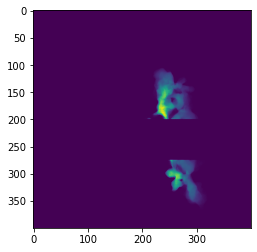

In [46]:
test = lifetimes[-1].sum(axis=0)
test[200:275,:] = 0
plt.imshow(test)

In [5]:
areas_mask = np.zeros((mask.shape[0]))
areas_neu = np.zeros((neuron.shape[0]))
areas_stable = np.zeros((stable_neuron.shape[0]))

In [6]:
for i  in tqdm(range(0,mask.shape[0])):
    verts, faces, normals, values = measure.marching_cubes(mask[i], step_size=2, spacing=(0.4,0.076,0.076))
    areas_mask[i] = measure.mesh_surface_area(verts, faces)

for i  in tqdm(range(0,neuron.shape[0])):
    verts, faces, normals, values = measure.marching_cubes(neuron[i], step_size=2, spacing=(0.4,0.076,0.076))
    areas_neu[i] = measure.mesh_surface_area(verts, faces)

for ind, stack in tqdm(enumerate(stable_neuron[4:], 4)):
    verts, faces, normals, values = measure.marching_cubes(stack, step_size=2, spacing=(0.4,0.076,0.076))
    areas_stable[ind] = measure.mesh_surface_area(verts, faces)
    

100%|██████████| 89/89 [00:03<00:00, 23.27it/s]
85it [00:03, 22.55it/s]


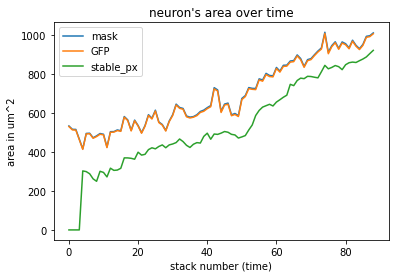

In [7]:
plt.plot(areas_mask, label='mask')
plt.plot(areas_neu, label='GFP')
plt.plot(areas_stable, label='stable_px')
plt.title("neuron's area over time")
plt.ylabel('area in um^2')
plt.xlabel('stack number (time)')
plt.legend()
plt.savefig('211104_N2_area_overtime.png')

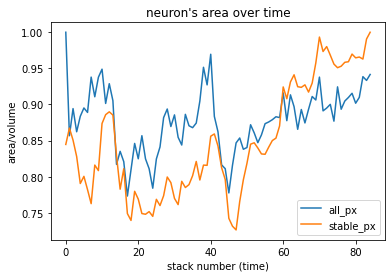

In [30]:
result_1 = areas_mask[4:]/mask[4:].sum(axis=(1,2,3))
result_1 = result_1/result_1.max()
result_2 = areas_stable[4:]/stable_neuron[4:].sum(axis=(1,2,3))
result_2 = result_2/result_2.max()
plt.plot(result_1, label='all_px')
plt.plot(result_2, label='stable_px')
plt.title("neuron's area over time")
plt.ylabel('area/volume')
plt.xlabel('stack number (time)')
plt.legend()
plt.savefig('211104_N2_area_to_volume_1.png')

In [18]:
from skimage import morphology, io
import numpy as np
from scipy import ndimage
import tqdm
import tifffile
import cv2
from os.path import join as pjoin
from dipy.viz import regtools
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import SSDMetric
from dipy.align.imaffine import transform_centers_of_mass




def dendritic_space_transform(neuron_hexagon, neuron_center, save_path, data_path, file_name):
    
    """
    This function will calculate the transform matrix from the hexagon lattice of the dendrite to a standardized hexagon.
    It takes in the neuron_hexagon and neuron_center coordinates as a numpy array.
    It returns the dipy transformation object for the aligning the centers and for the transformation.
    It saves the images of the transform.
    The image space is supposed to be 400 x 400 pixels.

    Bugs: 
    It might be possible that the shape generation does not lead to a filled object which can lead to no succesful transform.

    Parameters:
    neuron_hexagon: should contain the six 2D coordinates of the column centers of the surrounding columns in image space
    neuron_center: should contain a single 2D coordinate for the central column in image space
    save_path: path to save the diffeomorphic grid deformation (for visualisation)
    data_path: path to a single channgel time lapse imaging file
    file_name: file_name of the transformed file
    
    
    
    Some variables:
    filled_to_filled: center of mass transform for two filled and adjusted hexagons that are used for the transformation
    raw_transform: moving the raw image to the center of mass of the regular hexagon
    mapping: transform object for diffeomorphic mapping between regular hexagon and neuron hexagon
    """
    neuron_hexagon = np.array(neuron_hexagon, np.int32)
    neuron_center = np.array(neuron_center, np.int32)
    neuron_hexagon_raw = neuron_hexagon - neuron_center

    neuron_hexagon = np.int32(np.round(neuron_hexagon_raw * (200/np.abs(neuron_hexagon_raw[:,1]).max()))) + np.array([200,200])
    neuron_hexagon_raw = neuron_hexagon_raw + neuron_center
    
    image = np.zeros((400,400))

    neuron_hexagon = neuron_hexagon.reshape((-1, 1, 2))
    isClosed = True
    thickness = 1

    neuron_hexagon_shape = cv2.polylines(image, [neuron_hexagon],
                          isClosed, thickness)

    neuron_hex_filled = np.array(ndimage.binary_fill_holes(neuron_hexagon_shape), dtype=np.float32)
    io.imshow(neuron_hex_filled)
    
    image = np.zeros((400,400))

    reg_hex = np.array([[200,0],
                    [26.8,100],
                    [26.8,300],
                    [200,400],
                    [373.2,300],
                    [373.2,100]
                   ], np.int32)

    reg_hex = reg_hex.reshape((-1, 1, 2))

    reg_hex_im = cv2.polylines(image, [reg_hex],
                          isClosed, thickness)
    reg_hex_im = morphology.dilation(reg_hex_im)

    subtract = reg_hex_im - morphology.erosion(reg_hex_im)


    reg_hex_filled = np.array(ndimage.binary_fill_holes(reg_hex_im), dtype=np.float32)-subtract
    
    image = np.zeros((400,400))
    
    
    neuron_hexagon_raw = neuron_hexagon_raw.reshape((-1, 1, 2))

    raw_im = cv2.polylines(image, [neuron_hexagon_raw],
                      isClosed, thickness)

    raw_im_filled = np.array(ndimage.binary_fill_holes(raw_im), dtype=np.float32)
    io.imshow(raw_im_filled)
                                       
    filled_to_filled = transform_centers_of_mass(static=reg_hex_filled,
                                static_grid2world=np.eye(3),
                                moving=neuron_hex_filled,
                                moving_grid2world=np.eye(3)
                               )
    neuron_hex_filled = filled_to_filled.transform(neuron_hex_filled)
                                       
    regtools.overlay_images(reg_hex_filled, neuron_hex_filled)
        
    raw_transform = transform_centers_of_mass(static=reg_hex_filled,
                                          static_grid2world=np.eye(3),
                                          moving=raw_im_filled,
                                          moving_grid2world=np.eye(3)
                                             )
    
    regtools.overlay_images(reg_hex_filled, raw_im_filled)
    
    dim = reg_hex_filled.ndim
    metric = SSDMetric(dim)
    level_iters = [200, 100, 50, 25]

    sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, inv_iter=50, ss_sigma_factor=2)
    mapping = sdr.optimize(reg_hex_filled, neuron_hex_filled)
    
    regtools.plot_2d_diffeomorphic_map(mapping, 10, fname=save_path + 'diffeomorphic_map.png', dpi=1000)
    
    data = tifffile.imread(data_path)
    
    stack_transformed = np.zeros(data.shape, np.int16)
    
    for timepoint in tqdm.tqdm(range(0,data.shape[0])):
        for vol_slice in range(0,data.shape[1]):
            stack_transformed[timepoint,vol_slice] = mapping.transform(
                raw_transform.transform(data[timepoint, vol_slice])
            )

    tifffile.imwrite(file=save_path + file_name, data=stack_transformed, **{'imagej':'TZYX', 'bigtiff':True})

    print('Done!')
    
    return stack_transformed

In [ ]:
neuron_hexagon = 
neuron_center = 
trans_neu = dendritic_space_transform(neuron_hexagon, neuron_center, 
                                    save_path='', data_path='', file_name='transformed.tif')

In [35]:
neu_PC = np.argwhere(stable_neuron)
neu_PC[:,0] -= neu_PC[:,0].min()

In [36]:
stable_neuron[-1,0].shape

(400, 400)

In [37]:
result = np.zeros_like(stable_neuron[0,0])
timepoint =  neu_PC[neu_PC[:,0]==30]
for y, line in enumerate(result):
    for x, px in enumerate(line):
        # print(y,x)
        subset = neu_PC[neu_PC[:,1] == y]
        subset = subset[subset[:,2] == x]
        r = subset[:,0].mean()
        result[y,x] = r 

<ipython-input-37-83815a561940>:8: RuntimeWarning: Mean of empty slice.
  r = subset[:,0].mean()
/Users/aichah/.local/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


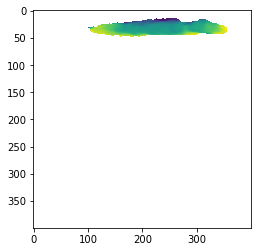

In [38]:
plt.imshow(result)

In [13]:
stable_neuron.sum(axis=(1,2,3)).shape, areas_stable.shape

((89,), (89,))

In [18]:
measure.mesh_surface_area(verts, faces)

610.4336000282904

In [12]:
verts, faces, normales, values = measure.marching_cubes(test[38], step_size=2)

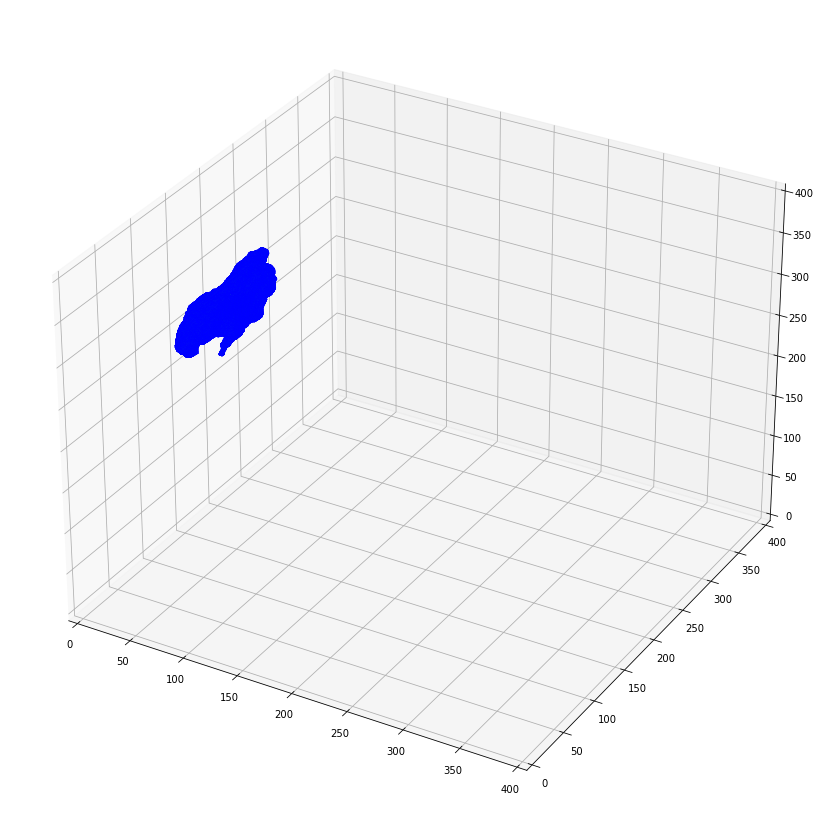

In [13]:
# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes_lewiner docstring).
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('b')
ax.add_collection3d(mesh)

# ax.set_xlabel("x-axis: a = 6 per ellipsoid")
# ax.set_ylabel("y-axis: b = 10")
# ax.set_zlabel("z-axis: c = 16")

ax.set_xlim(0, 400)  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(0, 400)  # b = 10
ax.set_zlim(0, 400)  # c = 16

plt.show()

In [ ]:
morphology.skeletonize_3d(test_skeletonize)

In [ ]:
test_skeletonize = verts / verts.max()

In [ ]:
io.imo